### Analyse entire data

In this notebook I analysed the offers for the sample dataset provided from EPEX Spot API.

           price_per_mwh                                                \
                   count        mean          std       min        25%   
date                                                                     
2021-06-26      872394.0  304.166724  1035.393609 -399960.0  16.402752   
2021-06-27     3084715.0  365.079454  1359.497240 -399960.0  14.796000   

                                             
                  50%         75%       max  
date                                         
2021-06-26  82.486486  253.866667   60040.0  
2021-06-27  67.208000  297.960000  399960.0  


<Figure size 1200x600 with 0 Axes>

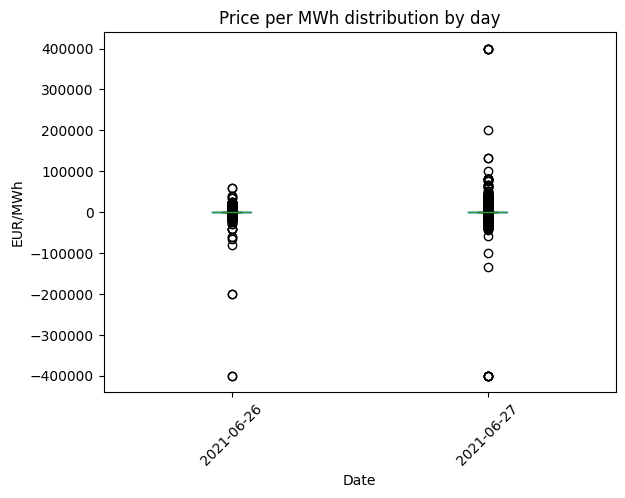

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df = pd.read_csv('../data/Continuous_Orders-DE-20210627-20210628T042307000Z.csv')

# Convert TransactionTime to datetime (if it's not already)
df["TransactionTime"] = pd.to_datetime(df["TransactionTime"], errors="coerce")

# Step 1: Keep only the latest revision for each OrderId
df = df.sort_values(by=["OrderId", "RevisionNo"], ascending=[True, False]).drop_duplicates(subset=["OrderId"], keep="first")

# Step 2: Remove orders that never became a transaction (TransactionTime is NaN)
df = df[df["TransactionTime"].notna()]

df = df[(df["Price"] != 0) & (df["Volume"] != 0)]

# 2) Convert DeliveryStart to a datetime
df["CreationTime"] = pd.to_datetime(df["CreationTime"], errors="coerce")


# 3) Create a "date" column (based on DeliveryStart) to group by day
df["date"] = df["CreationTime"].dt.date

# 4) Convert Price and Volume to floats (if they aren't already)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# 5) Calculate price per MWh (if "Price" is total for 'Volume' MWh)
df["price_per_mwh"] = df["Price"] / df["Volume"]

# 6) Drop any rows with missing or invalid values
df.dropna(subset=["price_per_mwh"], inplace=True)

# 7) Check basic stats
print(df[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


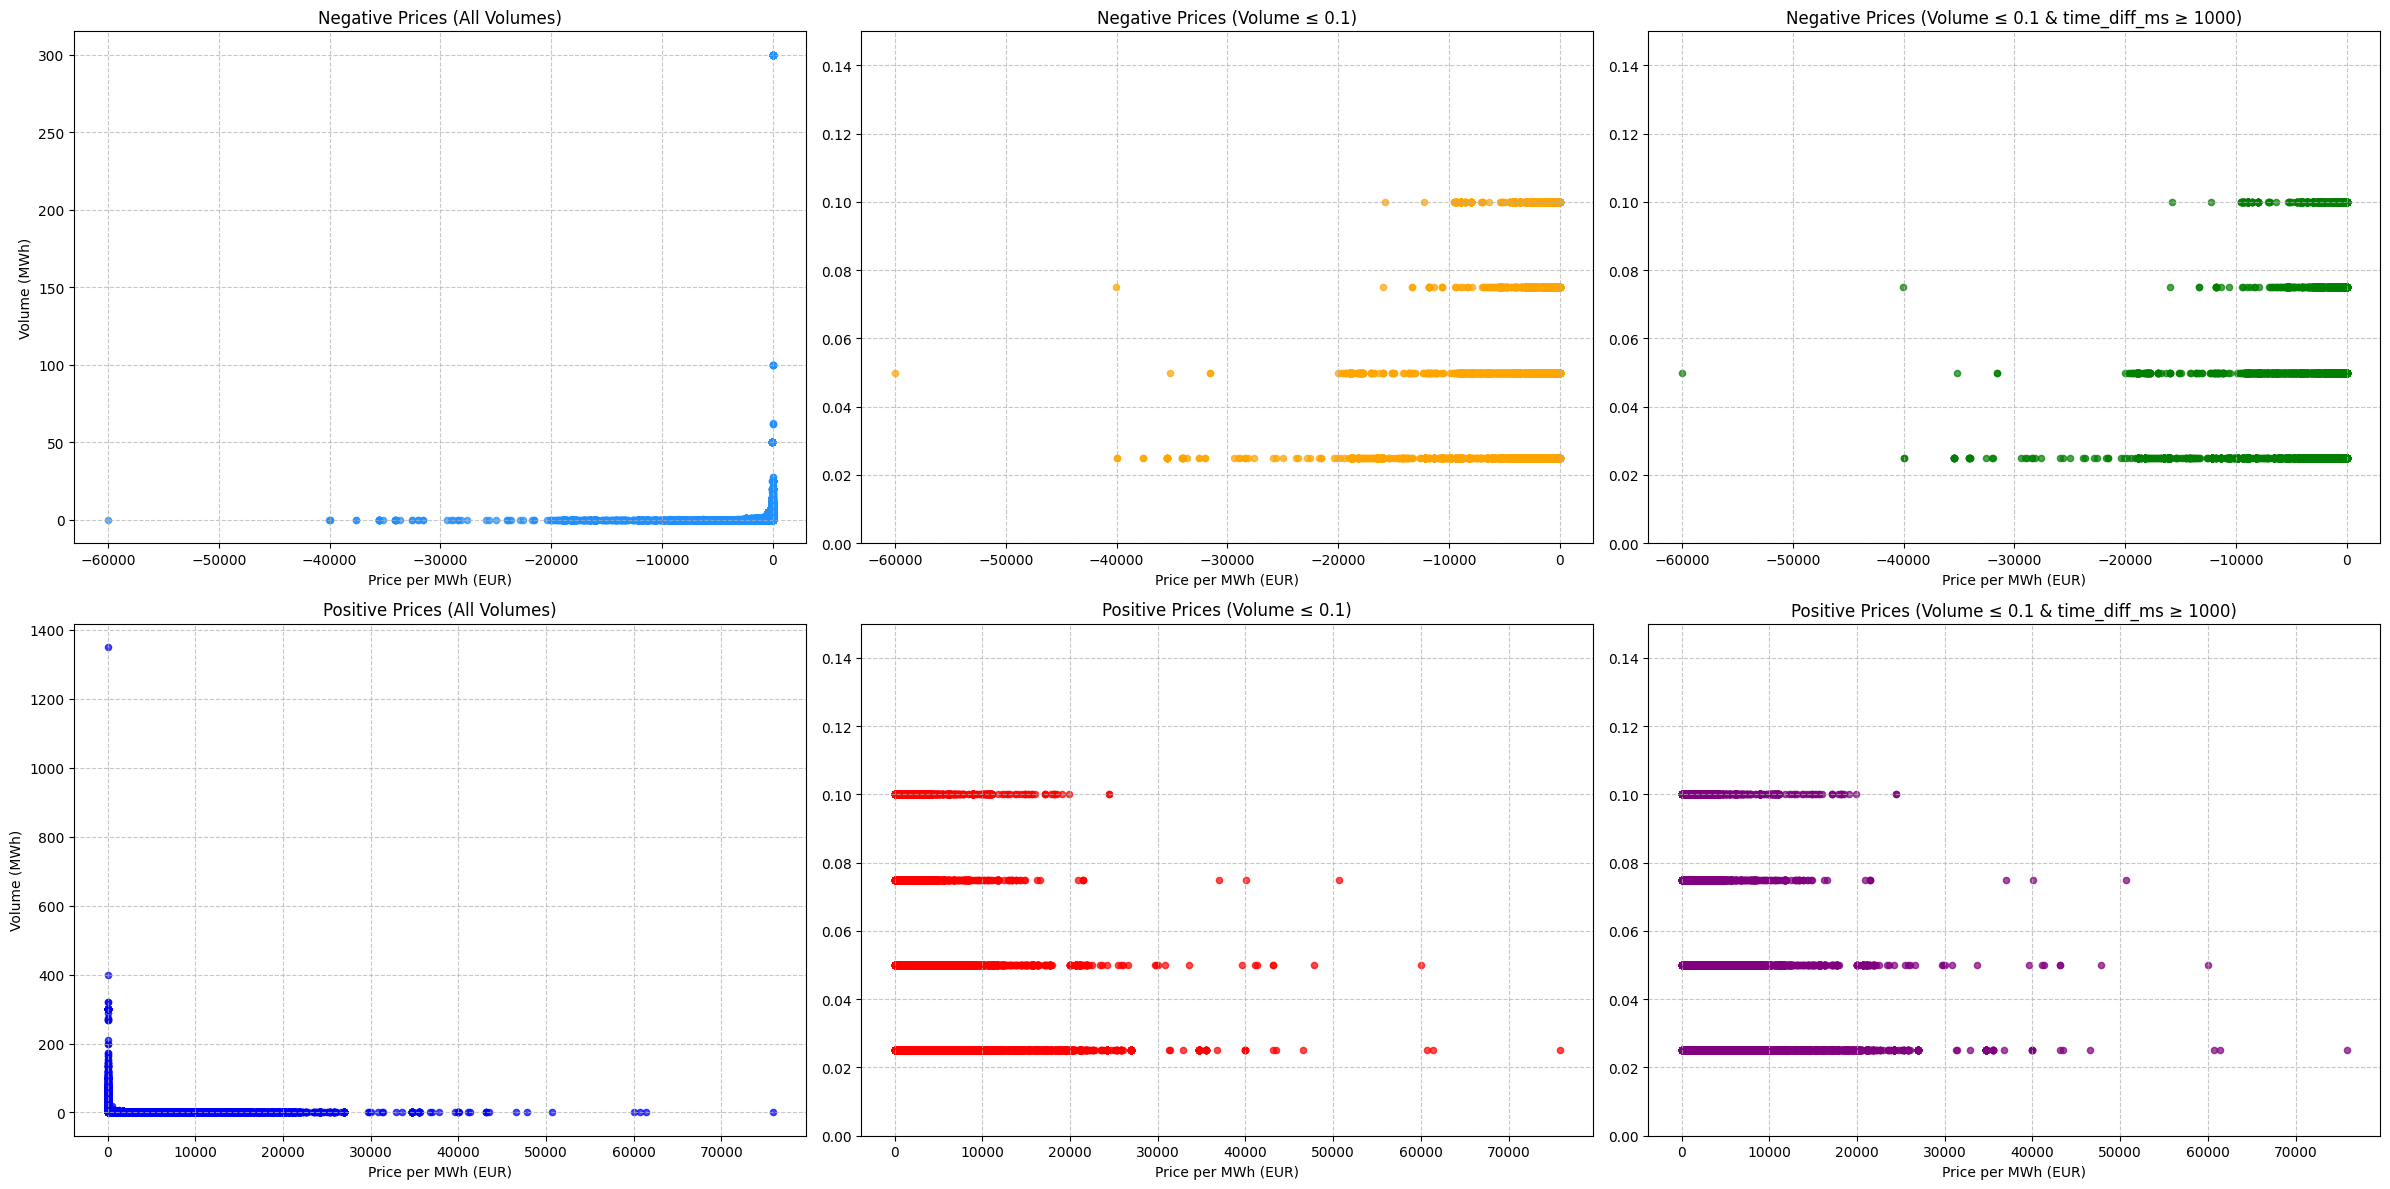

Summary Table for Negative Prices:
                 Metric        Value
0     Total Count (Neg)      9920.00
1    Total Volume (Neg)       536.15
2  Total Negative Price -21996068.90

Summary Table for Positive Prices:
                 Metric         Value
0     Total Count (Pos)  2.532410e+05
1    Total Volume (Pos)  1.425187e+04
2  Total Positive Price  4.303836e+08


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert columns to datetime if not done yet
df["CreationTime"] = pd.to_datetime(df["CreationTime"], errors="coerce")
df["TransactionTime"] = pd.to_datetime(df["TransactionTime"], errors="coerce")

# Calculate the time difference in milliseconds
df["time_diff_ms"] = (df["TransactionTime"].astype("int64") - df["CreationTime"].astype("int64")) // 1_000_000

### Handling Negative Prices ###
negative_prices = df[df['price_per_mwh'] < 0]
filtered_negative = negative_prices[negative_prices["Volume"] <= 0.1]
filtered_negative_large_time_diff = filtered_negative[filtered_negative["time_diff_ms"] >= 1000]

# Sorting
sorted_negative = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_negative = filtered_negative.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff_negative = filtered_negative_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

### Handling Positive Prices ###
positive_prices = df[df['price_per_mwh'] > 0]
filtered_positive = positive_prices[positive_prices["Volume"] <= 0.1]
filtered_positive_large_time_diff = filtered_positive[filtered_positive["time_diff_ms"] >= 1000]

# Sorting
sorted_positive = positive_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_positive = filtered_positive.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff_positive = filtered_positive_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create six subplots (3 for negative prices, 3 for positive prices)
fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey=False)

# Plot 1: All negative prices
axes[0, 0].scatter(
    sorted_negative["price_per_mwh"],
    sorted_negative["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0, 0].set_title("Negative Prices (All Volumes)")
axes[0, 0].set_xlabel("Price per MWh (EUR)")
axes[0, 0].set_ylabel("Volume (MWh)")
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume ≤ 0.1
axes[0, 1].scatter(
    sorted_filtered_negative["price_per_mwh"],
    sorted_filtered_negative["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[0, 1].set_title("Negative Prices (Volume ≤ 0.1)")
axes[0, 1].set_xlabel("Price per MWh (EUR)")
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].set_ylim(0, 0.15)

# Plot 3: Negative prices with Volume ≤ 0.1 & time_diff_ms ≥ 1000
axes[0, 2].scatter(
    sorted_large_time_diff_negative["price_per_mwh"],
    sorted_large_time_diff_negative["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[0, 2].set_title("Negative Prices (Volume ≤ 0.1 & time_diff_ms ≥ 1000)")
axes[0, 2].set_xlabel("Price per MWh (EUR)")
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].set_ylim(0, 0.15)

# Plot 4: All positive prices
axes[1, 0].scatter(
    sorted_positive["price_per_mwh"],
    sorted_positive["Volume"],
    alpha=0.7,
    s=20,
    color='blue'
)
axes[1, 0].set_title("Positive Prices (All Volumes)")
axes[1, 0].set_xlabel("Price per MWh (EUR)")
axes[1, 0].set_ylabel("Volume (MWh)")
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 5: Positive prices with Volume ≤ 0.1
axes[1, 1].scatter(
    sorted_filtered_positive["price_per_mwh"],
    sorted_filtered_positive["Volume"],
    alpha=0.7,
    s=20,
    color='red'
)
axes[1, 1].set_title("Positive Prices (Volume ≤ 0.1)")
axes[1, 1].set_xlabel("Price per MWh (EUR)")
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].set_ylim(0, 0.15)

# Plot 6: Positive prices with Volume ≤ 0.1 & time_diff_ms ≥ 1000
axes[1, 2].scatter(
    sorted_large_time_diff_positive["price_per_mwh"],
    sorted_large_time_diff_positive["Volume"],
    alpha=0.7,
    s=20,
    color='purple'
)
axes[1, 2].set_title("Positive Prices (Volume ≤ 0.1 & time_diff_ms ≥ 1000)")
axes[1, 2].set_xlabel("Price per MWh (EUR)")
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].set_ylim(0, 0.15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms (Negative Prices)
total_count_neg = len(filtered_negative_large_time_diff)
total_volume_neg = filtered_negative_large_time_diff["Volume"].sum()
total_negative_price = filtered_negative_large_time_diff["price_per_mwh"].sum()

summary_table_neg = pd.DataFrame({
    "Metric": ["Total Count (Neg)", "Total Volume (Neg)", "Total Negative Price"],
    "Value": [total_count_neg, total_volume_neg, total_negative_price]
})

# Summary table for transactions with time_diff_ms >= 1000 ms (Positive Prices)
total_count_pos = len(filtered_positive_large_time_diff)
total_volume_pos = filtered_positive_large_time_diff["Volume"].sum()
total_positive_price = filtered_positive_large_time_diff["price_per_mwh"].sum()

summary_table_pos = pd.DataFrame({
    "Metric": ["Total Count (Pos)", "Total Volume (Pos)", "Total Positive Price"],
    "Value": [total_count_pos, total_volume_pos, total_positive_price]
})

# Print the summary tables
print("Summary Table for Negative Prices:")
print(summary_table_neg)
print("\nSummary Table for Positive Prices:")
print(summary_table_pos)


The graphs above display the following:
1. Distribution of all negative transactions
2. Distribution of all negative transactions where the volume is below or equal to 100kWH
3. Distribution of all negative transactions where the volume is below or equal to 100kWH and the timeframe between creation and transactio of the over is bigger than 1000ms or 1s

In [ ]:
relevant_metrics = filtered_negative_large_time_diff[['Price','Quantity','Volume','price_per_mwh','time_diff_ms']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
relevant_metrics.rename(columns={
    "count": "Total Count",
    "mean": "Mean",
    "std": "Standard Deviation",
    "min": "Minimum",
    "10%": "10th Percentile",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "90%": "90th Percentile",
    "95%": "95th Percentile",
    "99%": "99th Percentile",
    "max": "Maximum"
}, inplace=True)

# Convert to a well-formatted table
relevant_metrics.reset_index(inplace=True)
relevant_metrics.rename(columns={"index": "Metric"}, inplace=True)

# Display the table
#print(relevant_metrics)


# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_negative_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_negative_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_negative_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_negative_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)

          Metric  Total Count           Mean  Standard Deviation    Minimum  \
0          Price      10214.0     -94.403465        1.713672e+02  -3002.000   
1       Quantity      10214.0       0.210437        1.120068e-01      0.100   
2         Volume      10214.0       0.054168        2.843146e-02      0.025   
3  price_per_mwh      10214.0   -2250.347128        4.093126e+03 -60040.000   
4   time_diff_ms      10214.0  456683.160760        1.631019e+06   1002.000   

   10th Percentile  25th Percentile    Median  75th Percentile  \
0         -265.790          -81.275    -31.67          -10.680   
1            0.100            0.100      0.20            0.300   
2            0.025            0.025      0.05            0.075   
3        -6262.200        -2353.600   -678.50         -220.000   
4         3941.600         7512.000  47727.50       686049.000   

   90th Percentile  95th Percentile  99th Percentile      Maximum  
0           -4.966            -2.35            -0.46        

### Analyse Sell Offers
Using the same analysation method but only for transactions that were put on the market for sell.

           price_per_mwh                                               \
                   count        mean          std       min       25%   
date                                                                    
2021-06-26      467825.0  377.444004  1249.997676 -399960.0  27.65000   
2021-06-27     1408295.0  483.974969  1552.148240 -399960.0  17.41476   

                                             
                   50%         75%      max  
date                                         
2021-06-26  107.883333  306.171429  60040.0  
2021-06-27   82.969697  396.342857  75840.0  


<Figure size 1200x600 with 0 Axes>

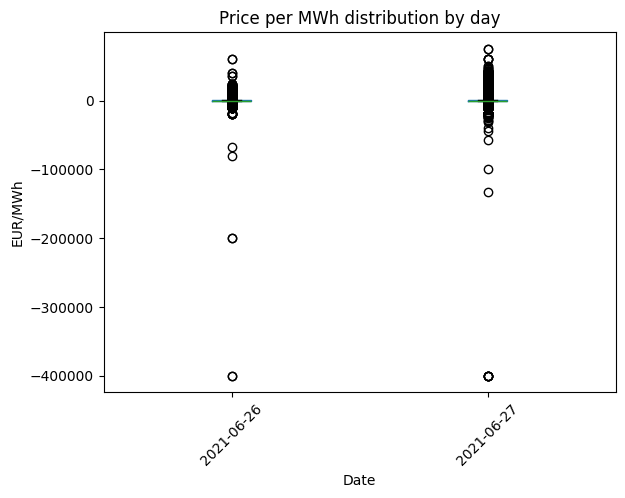

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df_sell = df[df["Side"] == 'SELL']

# 7) Check basic stats
print(df_sell[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df_sell.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


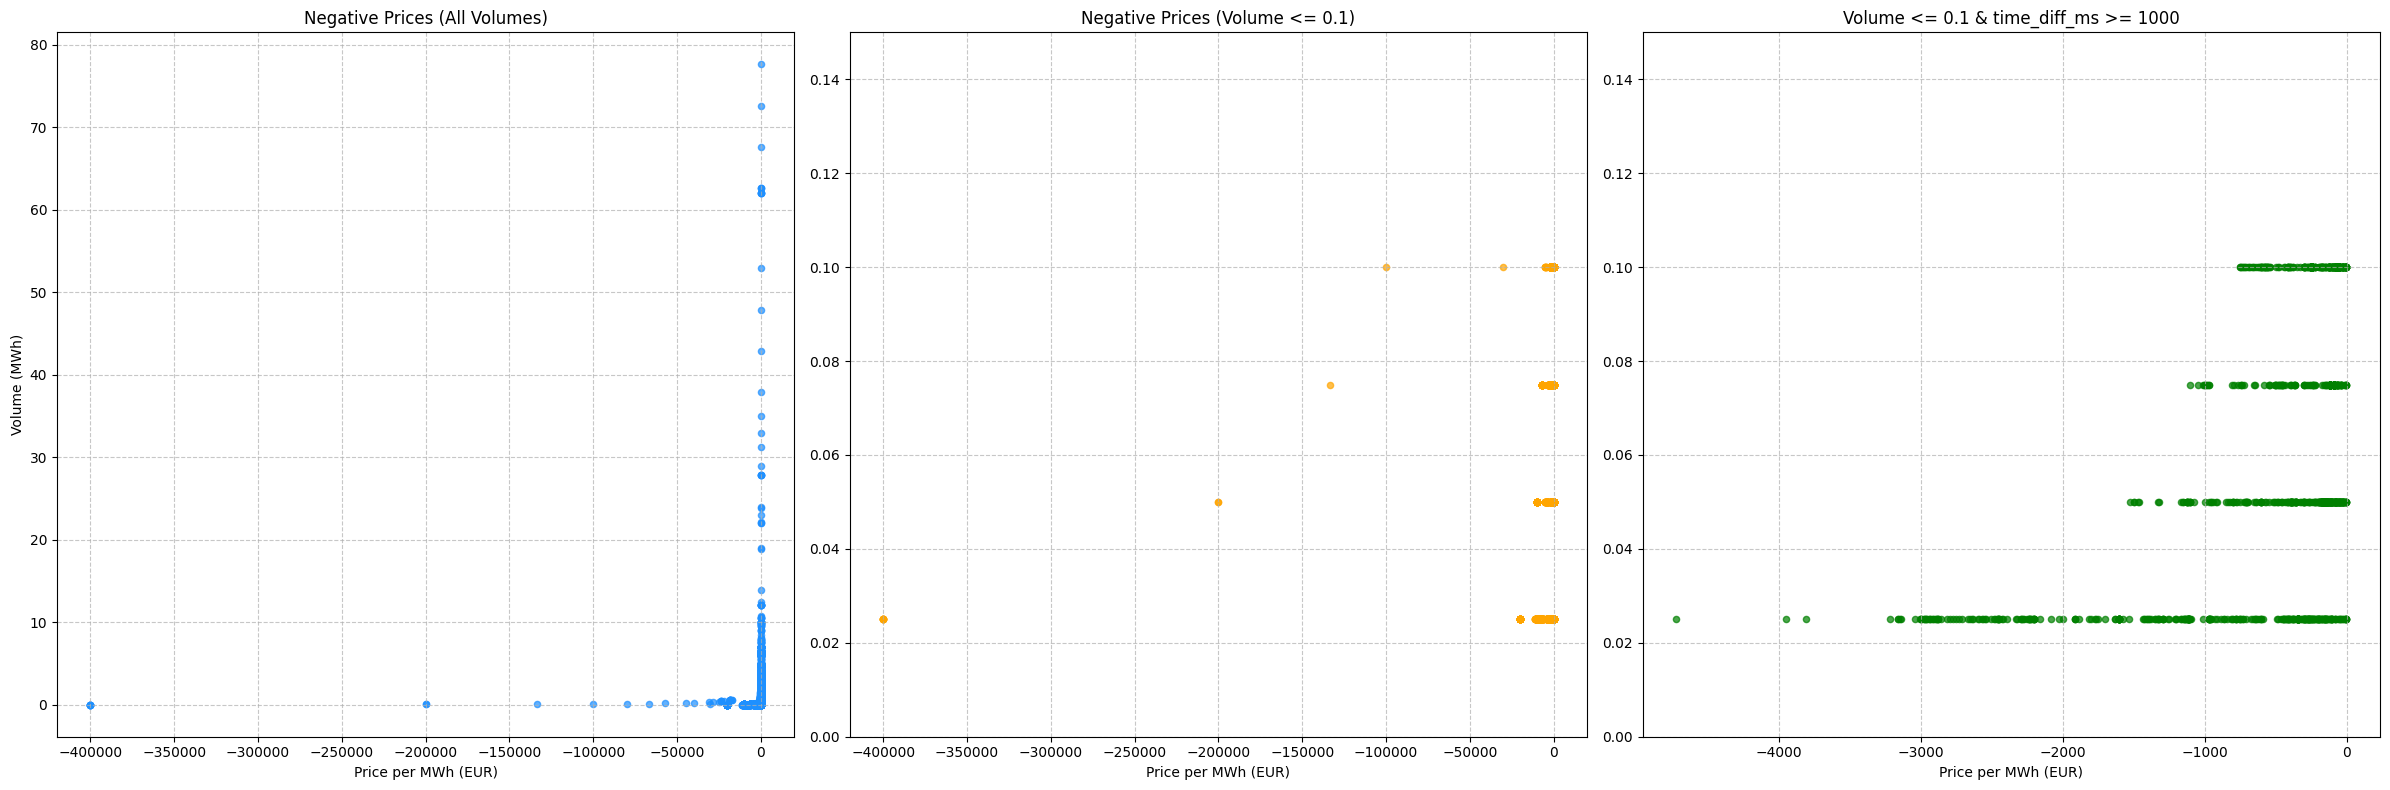

                 Metric    Value
0           Total Count   1546.0
1          Total Volume    106.8
2  Total Negative Price -26923.7


In [21]:
# Filter for negative prices
negative_prices = df_sell[df_sell['price_per_mwh'] < 0]

# Filter for negative prices with Volume <= 0.1
filtered_prices = negative_prices[negative_prices["Volume"] <= 0.1]

# Additional filter: Transactions with time_diff_ms >= 1000 ms
filtered_large_time_diff = filtered_prices[filtered_prices["time_diff_ms"] >= 1000]

# Ensure all datasets are sorted by price_per_mwh in descending order
sorted_df = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_df = filtered_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff = filtered_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Plot 1: All negative prices
axes[0].scatter(
    sorted_df["price_per_mwh"],
    sorted_df["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0].set_title("Negative Prices (All Volumes)")
axes[0].set_xlabel("Price per MWh (EUR)")
axes[0].set_ylabel("Volume (MWh)")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume <= 0.1
axes[1].scatter(
    sorted_filtered_df["price_per_mwh"],
    sorted_filtered_df["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[1].set_title("Negative Prices (Volume <= 0.1)")
axes[1].set_xlabel("Price per MWh (EUR)")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Plot 3: Filtered transactions with time_diff_ms >= 1000 ms
axes[2].scatter(
    sorted_large_time_diff["price_per_mwh"],
    sorted_large_time_diff["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[2].set_title("Volume <= 0.1 & time_diff_ms >= 1000")
axes[2].set_xlabel("Price per MWh (EUR)")
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms
total_count = len(filtered_large_time_diff)
total_volume = filtered_large_time_diff["Volume"].sum()
total_negative_price = filtered_large_time_diff["Price"].sum()

# Create and print the summary table
summary_table = pd.DataFrame({
    "Metric": ["Total Count", "Total Volume", "Total Negative Price"],
    "Value": [total_count, total_volume, total_negative_price]
})

print(summary_table)

In [22]:
import pandas as pd

# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)


Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%         0.775     -1547.47
1          1%-5%         2.975     -4173.29
2         5%-10%         4.150     -4457.06
3        10%-25%        14.175     -7887.79
4        25%-50%        22.900     -5009.04
5        50%-75%        32.750     -2367.22
6        75%-90%        20.325     -1158.93
7       90%-100%         8.750      -322.90


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_92447/3343403287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_92447/3343403287.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(


### Analye BUY Offers
Using the same analysation method but only for transactions that were put on the market to buy.

           price_per_mwh                                                 \
                   count        mean          std           min     25%   
date                                                                      
2021-06-26      404569.0  219.432244   701.080976 -60040.000000  12.065   
2021-06-27     1676420.0  265.199972  1164.116047 -40026.666667  12.406   

                                             
                  50%         75%       max  
date                                         
2021-06-26  61.760000  202.986667   20000.0  
2021-06-27  55.142857  230.460000  399960.0  


<Figure size 1200x600 with 0 Axes>

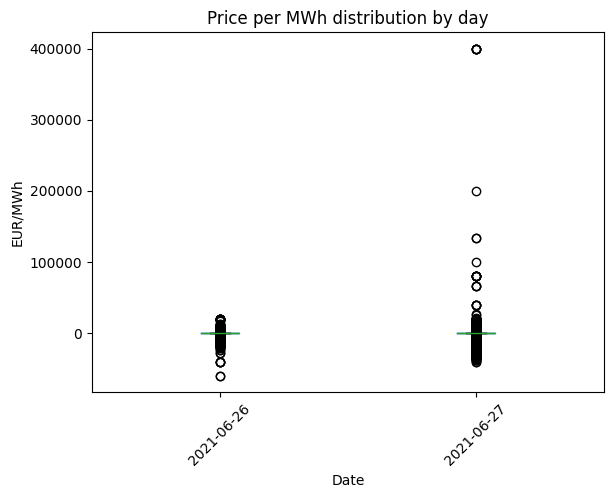

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the CSV (adjust the filename/path)
df_buy = df[df["Side"] == 'BUY']

# 7) Check basic stats
print(df_buy[["date", "price_per_mwh"]].groupby("date").describe())

# 8) Plot a distribution (boxplot) of prices per day
plt.figure(figsize=(12,6))
df_buy.boxplot(column="price_per_mwh", by="date", grid=False, rot=45)
plt.title("Price per MWh distribution by day")
plt.suptitle("")  # Remove default title
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()


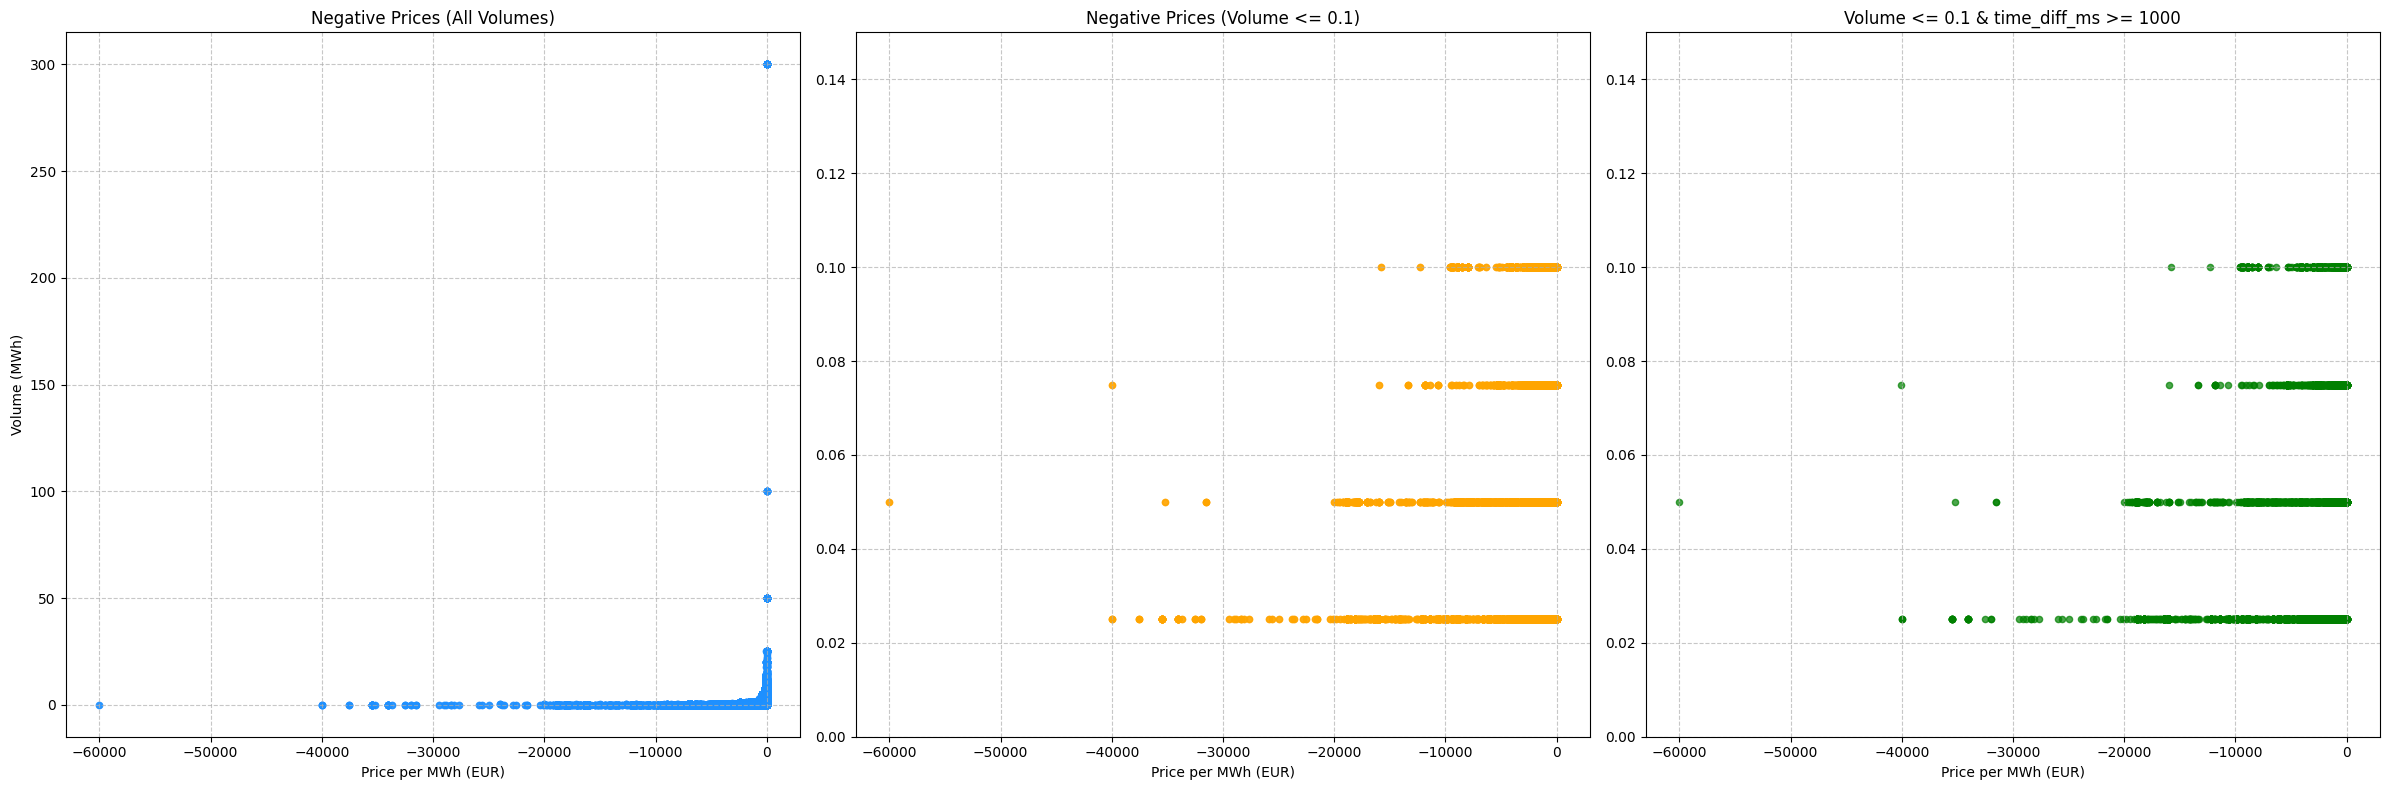

                 Metric       Value
0           Total Count    8668.000
1          Total Volume     446.475
2  Total Negative Price -937313.290


In [24]:
# Filter for negative prices
negative_prices = df_buy[df_buy['price_per_mwh'] < 0]

# Filter for negative prices with Volume <= 0.1
filtered_prices = negative_prices[negative_prices["Volume"] <= 0.1]

# Additional filter: Transactions with time_diff_ms >= 1000 ms
filtered_large_time_diff = filtered_prices[filtered_prices["time_diff_ms"] >= 1000]

# Ensure all datasets are sorted by price_per_mwh in descending order
sorted_df = negative_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_filtered_df = filtered_prices.sort_values(by="price_per_mwh", ascending=False).reset_index()
sorted_large_time_diff = filtered_large_time_diff.sort_values(by="price_per_mwh", ascending=False).reset_index()

# Create three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Plot 1: All negative prices
axes[0].scatter(
    sorted_df["price_per_mwh"],
    sorted_df["Volume"],
    alpha=0.7,
    s=20,
    color='dodgerblue'
)
axes[0].set_title("Negative Prices (All Volumes)")
axes[0].set_xlabel("Price per MWh (EUR)")
axes[0].set_ylabel("Volume (MWh)")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Negative prices with Volume <= 0.1
axes[1].scatter(
    sorted_filtered_df["price_per_mwh"],
    sorted_filtered_df["Volume"],
    alpha=0.7,
    s=20,
    color='orange'
)
axes[1].set_title("Negative Prices (Volume <= 0.1)")
axes[1].set_xlabel("Price per MWh (EUR)")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Plot 3: Filtered transactions with time_diff_ms >= 1000 ms
axes[2].scatter(
    sorted_large_time_diff["price_per_mwh"],
    sorted_large_time_diff["Volume"],
    alpha=0.7,
    s=20,
    color='green'
)
axes[2].set_title("Volume <= 0.1 & time_diff_ms >= 1000")
axes[2].set_xlabel("Price per MWh (EUR)")
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 0.15)  # Adjust y-axis for smaller volumes

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Summary table for transactions with time_diff_ms >= 1000 ms
total_count = len(filtered_large_time_diff)
total_volume = filtered_large_time_diff["Volume"].sum()
total_negative_price = filtered_large_time_diff["Price"].sum()

# Create and print the summary table
summary_table = pd.DataFrame({
    "Metric": ["Total Count", "Total Volume", "Total Negative Price"],
    "Value": [total_count, total_volume, total_negative_price]
})

print(summary_table)

In [25]:
import pandas as pd

# Define the quantile probabilities including the full range
quantile_probs = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Calculate bin edges based on quantiles
quantile_bins = filtered_large_time_diff['Price'].quantile(quantile_probs).values

# Create labels using the quantile percentages (e.g. "0%-10%", "10%-25%", etc.)
quantile_labels = [f"{int(p*100)}%-{int(q*100)}%" for p, q in zip(quantile_probs, quantile_probs[1:])]

print(f"Number of bin edges: {len(quantile_bins)}, Number of labels: {len(quantile_labels)}")

# Bin the Price data into quantile ranges
filtered_large_time_diff["Price_Quantile"] = pd.cut(
    filtered_large_time_diff["Price"], 
    bins=quantile_bins, 
    labels=quantile_labels,
    include_lowest=True
)

# Group by quantile range and calculate the sum of Price and Volume
quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(
    Total_Volume=("Volume", "sum"),
    Total_Price=("Price", "sum")
).reset_index()

# Display the summary table
print(quantile_summary)

Number of bin edges: 9, Number of labels: 8
  Price_Quantile  Total_Volume  Total_Price
0          0%-1%         6.025    -92717.40
1          1%-5%        19.025   -224380.48
2         5%-10%        23.625   -165636.11
3        10%-25%        66.450   -248428.62
4        25%-50%       109.375   -136620.69
5        50%-75%       113.825    -54464.55
6        75%-90%        63.875    -12987.20
7       90%-100%        44.275     -2078.24


/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_92447/1537614606.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_large_time_diff["Price_Quantile"] = pd.cut(
/var/folders/_k/gccc3rkn2wv6_r5b1mgv2szc0000gp/T/ipykernel_92447/1537614606.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_summary = filtered_large_time_diff.groupby("Price_Quantile").agg(


In [27]:
len(df)

3957109